In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing pandas
import numpy as np
import pandas as pd
from pandas.core.internals.blocks import F

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors, datasets
#from sklearn.inspection import DecisionBoundaryDisplay

import sklearn.metrics
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [ ]:
col = [4,5,6,7, 10,11,12,15]
Dos= pd.read_csv('/content/drive/MyDrive/colab_data/dataset/bigdata/DoS_dataset_pre.csv',usecols=col)
Fuzzy=pd.read_csv('/content/drive/MyDrive/colab_data/dataset/bigdata/Fuzzy_dataset_pre.csv',usecols=col)
Rpm=pd.read_csv('/content/drive/MyDrive/colab_data/dataset/bigdata/RPM_dataset_pre.csv',usecols=col)
#,usecols = col

In [ ]:
Dataset = pd.concat((Dos, Fuzzy, Rpm))

def sampling_func(data, n_sample):
    np.random.seed(10) #실행할 때마다 동일한 샘플을 추출하기 위해 random seed 고정
    N = len(data)
    sample = data.take(np.random.permutation(N)[:n_sample])
    return sample

SampledDataset = Dataset.groupby('Label', group_keys=False).apply(sampling_func, n_sample=250000)

In [ ]:
X = SampledDataset.drop(['Label'], axis=1)
y = SampledDataset['Label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 1)

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
X_train

array([[-0.37585774, -0.78578224,  2.98274631, ...,  2.82181512,
        -0.07626653,  0.33306728],
       [ 0.06509982, -0.18752868, -0.20942697, ..., -0.54659859,
         1.35091951, -0.32379195],
       [ 1.12072547,  0.27266637,  2.92223117, ...,  1.95116581,
         0.38116489,  1.73330381],
       ...,
       [-0.85690234, -0.81646191, -0.75406317, ..., -0.54659859,
        -0.98198075, -0.32170354],
       [-0.85690234, -0.81646191, -0.73893439, ..., -0.54659859,
        -0.98198075, -0.31104711],
       [-0.85690234, -0.81646191, -0.75406317, ..., -0.54659859,
        -0.98198075, -0.32387813]])

# AutoEncoder

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Autoencoder 클래스 정의
class Autoencoder(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim, optimizer='adam', epochs=10, batch_size=32):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None

    def fit(self, X, y=None):
        input_layer = Input(shape=(self.input_dim,))
        encoded = Dense(self.encoding_dim, activation='relu')(input_layer)
        decoded = Dense(self.input_dim, activation='sigmoid')(encoded)

        self.autoencoder = Model(inputs=input_layer, outputs=decoded)
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

        self.autoencoder.fit(X, X, epochs=self.epochs, batcㄴh_size=self.batch_size, verbose=0)

        return self

    def transform(self, X):
        encoder = Model(inputs=self.autoencoder.input, outputs=self.autoencoder.get_layer(index=1).output)
        decoder_input = Input(shape=(self.encoding_dim,))
        decoded = self.autoencoder.layers[-1](decoder_input)
        decoder = Model(inputs=decoder_input, outputs=decoded)

        encoded_X = encoder.predict(X)
        decoded_X = decoder.predict(encoded_X)

        return decoded_X


In [ ]:
autoencoder_params = {
    'input_dim': X_train.shape[1],
    'encoding_dim': 5,
    'optimizer': 'adam',
    'epochs': 10,
    'batch_size': 32
}


In [ ]:
print(X_train.shape[1])

7


In [ ]:
# Autoencoder 모델 학습
autoencoder = Autoencoder(
    input_dim=autoencoder_params['input_dim'],
    encoding_dim=autoencoder_params['encoding_dim'],
    optimizer=autoencoder_params['optimizer'],
    epochs=autoencoder_params['epochs'],
    batch_size=autoencoder_params['batch_size']
)
autoencoder.fit(X_train)

Autoencoder(encoding_dim=5, input_dim=7)

In [ ]:
# Autoencoder를 사용하여 특징 추출
encoded_X_train = autoencoder.transform(X_train)
encoded_X_test = autoencoder.transform(X_test)

6250/6250 [==============================] - 5s 765us/step


In [ ]:
print(encoded_X_train.shape[1])
print(encoded_X_test.shape[1])

7
7


In [ ]:
print(encoded_X_train)

[[ 3.658684   12.181835    8.055972    3.8060982   6.6524453 ]
 [ 4.4053273   0.08228421  0.968308    1.8339853   0.40672874]
 [ 2.9972134   9.156472    7.1162386   0.          6.2203546 ]
 ...
 [ 4.0765314   2.935912    3.3590107   8.221619    3.5969906 ]
 [ 4.0707636   2.9425192   3.3796048   8.180082    3.5848904 ]
 [ 4.076585    2.9359891   3.3591037   8.229324    3.5969799 ]]


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric = 'manhattan')

In [ ]:
knn.fit(encoded_X_train,y_train)
knn.score(encoded_X_test,y_test)

0.998695

Text(50.722222222222214, 0.5, 'True Class')

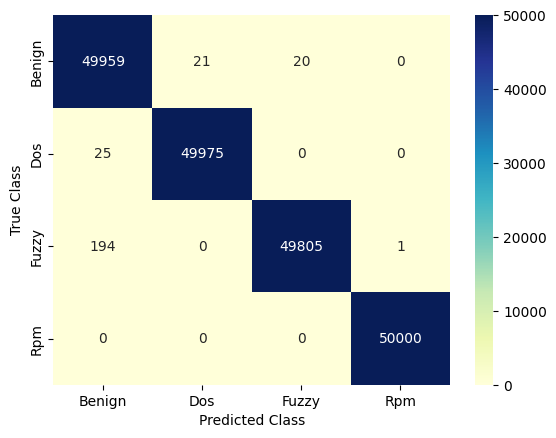

In [ ]:
import seaborn
y_pred = knn.predict(encoded_X_test)
cm = confusion_matrix(y_test, y_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Benign', 'Dos', 'Fuzzy','Rpm'],
                                 index=['Benign', 'Dos', 'Fuzzy','Rpm'])

s = seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
s.set_xlabel('Predicted Class')
s.set_ylabel('True Class')

In [ ]:
#evaluation for KNN

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='macro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='macro'))
print("F1_Score:",metrics.f1_score(y_test, y_pred, average='macro'))
print("Cohen_Kappa_Score:",sklearn.metrics.cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None))

Accuracy: 0.998695
Precision: 0.9986985248416603
Recall: 0.998695
F1_Score: 0.9986952080950356
Cohen_Kappa_Score: 0.99826


In [ ]:
# Individual Clasification- KNN

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50000
           1       1.00      1.00      1.00     50000
           2       1.00      1.00      1.00     50000
           3       1.00      1.00      1.00     50000

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



# **IF_REAL_auto**

In [ ]:

# Isolation Forest 모델 생성 및 학습
contamination = 'auto'
clf = IsolationForest(n_estimators=100, max_samples=len(encoded_X_train), contamination=contamination,random_state=5, verbose=0)  # 이상치 비율 설정
clf.fit(encoded_X_train)
scores_prediction = clf.decision_function(encoded_X_train)
y_pred = clf.predict(encoded_X_test)

In [ ]:
#Reshape the prediction values to 0 for Valid transactions , 2 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 2
print(contamination)

auto


Accuracy Score :
0.8711062659226958
Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.99      0.93    669403
           2       0.48      0.06      0.11     98369

    accuracy                           0.87    767772
   macro avg       0.68      0.53      0.52    767772
weighted avg       0.83      0.87      0.82    767772



<Axes: >

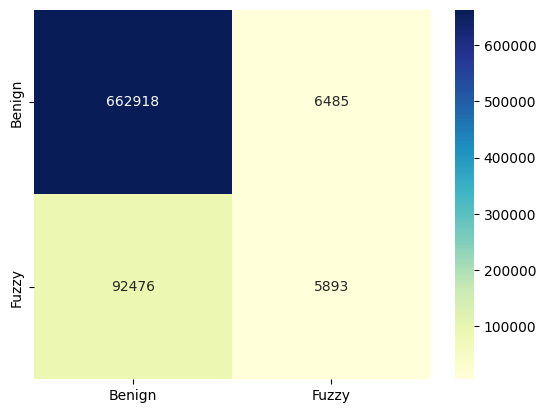

In [ ]:

#y_pred랑 y_test랑 비교해야함
import seaborn
print("Accuracy Score :")
print(accuracy_score(Y_test,y_pred))
print("Classification Report :")
print(classification_report(Y_test,y_pred))

cm = confusion_matrix(Y_test, y_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Benign','Fuzzy'],
                              index=['Benign', 'Fuzzy'])

seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# **0.01**

In [ ]:

# Isolation Forest 모델 생성 및 학습
clf = IsolationForest(n_estimators=100, max_samples=len(encoded_X_train), contamination=0.01,random_state=5, verbose=1)  # 이상치 비율 설정
clf.fit(encoded_X_train)
scores_prediction = clf.decision_function(encoded_X_train)
y_pred = clf.predict(encoded_X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min finished


In [ ]:
#Reshape the prediction values to 0 for Valid transactions , 2 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 2

Accuracy Score :
0.8691004621163575
Classification Report :
              precision    recall  f1-score   support

           0       0.87      0.99      0.93    669403
           2       0.37      0.03      0.06     98369

    accuracy                           0.87    767772
   macro avg       0.62      0.51      0.49    767772
weighted avg       0.81      0.87      0.82    767772



<Axes: >

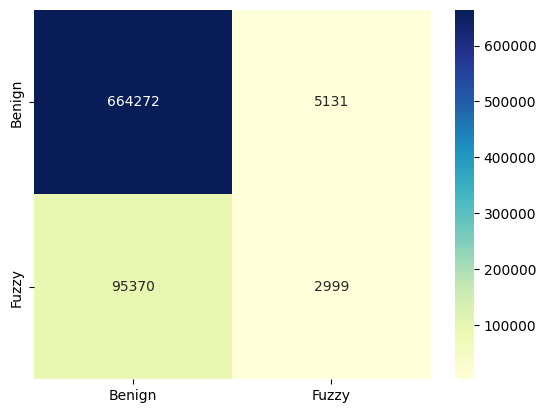

In [ ]:

#y_pred랑 y_test랑 비교해야함
import seaborn
print("Accuracy Score :")
print(accuracy_score(Y_test,y_pred))
print("Classification Report :")
print(classification_report(Y_test,y_pred))

cm = confusion_matrix(Y_test, y_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Benign','Fuzzy'],
                              index=['Benign', 'Fuzzy'])

seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# **여기다가 CNN 써보기**

In [ ]:
encoded_X_train

array([[ 0.6666417,  7.4249773,  0.       , ...,  1.1468525,  2.5787022,
         3.8386629],
       [ 3.545571 ,  2.8204615,  4.599457 , ...,  6.3602533,  5.816581 ,
         0.       ],
       [ 6.6002636,  9.255035 ,  7.9016886, ..., 15.091133 ,  9.915556 ,
         4.3222694],
       ...,
       [ 8.284691 ,  4.347114 ,  8.367382 , ..., 18.119646 ,  6.3259897,
         4.1327634],
       [10.097128 ,  6.348881 ,  4.7546544, ..., 12.8228855,  4.537938 ,
         5.744321 ],
       [ 7.86147  ,  1.827328 ,  9.483187 , ...,  4.737997 ,  0.       ,
         5.6100693]], dtype=float32)

In [ ]:
CNN_encoded_X_train = [[[x] for x in sublist] for sublist in encoded_X_train]

In [ ]:
CNN_encoded_X_test = [[[x] for x in sublist] for sublist in encoded_X_test]

In [ ]:
CNN_encoded_X_train

In [ ]:
CNN_encoded_X_train = np.expand_dims(encoded_X_train, axis=2)
CNN_encoded_X_test = np.expand_dims(encoded_X_test, axis=2)


In [ ]:
CNN_encoded_X_train

array([[[ 9.652079  ],
        [ 6.84285   ],
        [ 5.3842573 ],
        ...,
        [ 4.0400753 ],
        [ 0.        ],
        [ 0.        ]],

       [[ 4.975828  ],
        [ 8.502856  ],
        [ 4.0274434 ],
        ...,
        [ 0.33588314],
        [ 6.761991  ],
        [ 3.6265435 ]],

       [[ 3.738635  ],
        [ 8.154762  ],
        [10.348822  ],
        ...,
        [10.282558  ],
        [ 9.406872  ],
        [ 3.4567342 ]],

       ...,

       [[ 3.059691  ],
        [ 0.50932026],
        [ 3.904595  ],
        ...,
        [ 0.        ],
        [ 7.0643883 ],
        [ 2.9458241 ]],

       [[ 5.143389  ],
        [ 8.113454  ],
        [ 6.2032604 ],
        ...,
        [ 1.2953901 ],
        [ 8.148229  ],
        [ 2.685679  ]],

       [[ 3.3570843 ],
        [ 8.777277  ],
        [ 3.2473536 ],
        ...,
        [ 3.5882423 ],
        [ 0.4798913 ],
        [ 3.538787  ]]], dtype=float32)

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Flatten,Conv1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(9, 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 32)             128       
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 64)             6208      
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               41088     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 47,682
Trainable params: 47,682
Non-trainable params: 0
_________________________________________________________________


In [ ]:
a=0
b=0
for i in Y_test:
  if i==0:
    a+=1
  else: b+=1

print(a,b)

669403 98369


In [ ]:
# 모델 컴파일
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit(CNN_encoded_X_train, Y_train, epochs=20, batch_size=16, validation_data=(CNN_encoded_X_test, Y_test))

# 모델 평가
loss, accuracy = model.evaluate(CNN_encoded_X_test, Y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/20


InvalidArgumentError: ignored

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs=range(len(acc))
plt.figure(figsize=(20, 6))

plt.plot(epochs, acc,color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc,color='orange', label='Validation Accuracy')
plt.legend(bbox_to_anchor=(1.15, 1.0), loc='upper right')
plt.title('Training VS Validation Accuracy')


In [ ]:
los=history.history['loss']
val_acc=history.history['val_loss']

epochs=range(len(los))
plt.figure(figsize=(20, 6))

plt.plot(epochs, loss,color='blue', label='Training Loss')
plt.plot(epochs, val_acc,color='orange', label='Validation Loss')
plt.legend(bbox_to_anchor=(1.15, 1.0), loc='upper right')
plt.title('Training VS Validation Los')

In [ ]:
import seaborn
y_pred = model.predict(CNN_encoded_X_test)
print(y_pred)

In [ ]:
y_pred_label = np.argmax(y_pred, axis=1)

print(y_pred_label)
y_test=np.squeeze(Y_test.values)

In [ ]:
cm = confusion_matrix(y_test, y_pred_label)

cm_matrix = pd.DataFrame(data=cm, columns=['Benign', 'Fuzzy'],
                                 index=['Benign','Fuzzy'])

import seaborn
seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')